In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa
import librosa.display
import librosa.feature
import os

In [2]:
PATH_TO_DATASET = os.path.join(".", "dataset")

In [3]:
df = pd.read_csv(os.path.join(PATH_TO_DATASET, "UrbanSound8K.csv"))
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
df = df.drop(["fsID", "start", "end", "salience"], axis=1)

df["path_to_audio"] = (
    PATH_TO_DATASET + os.sep + "fold" + df["fold"].astype(str) + os.sep + df["slice_file_name"]
)

In [5]:
df.head()

,slice_file_name,fold,classID,class,path_to_audio
0,100032-3-0-0.wav,5,3,dog_bark,.\dataset\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-137.wav


In [6]:
sample_row_idx = 42
sample_file_name = df.at[sample_row_idx, "path_to_audio"]
sample_class = df.at[sample_row_idx, "class"]

print(f"Sample class: {sample_class}")

Audio(sample_file_name)

Sample class: air_conditioner


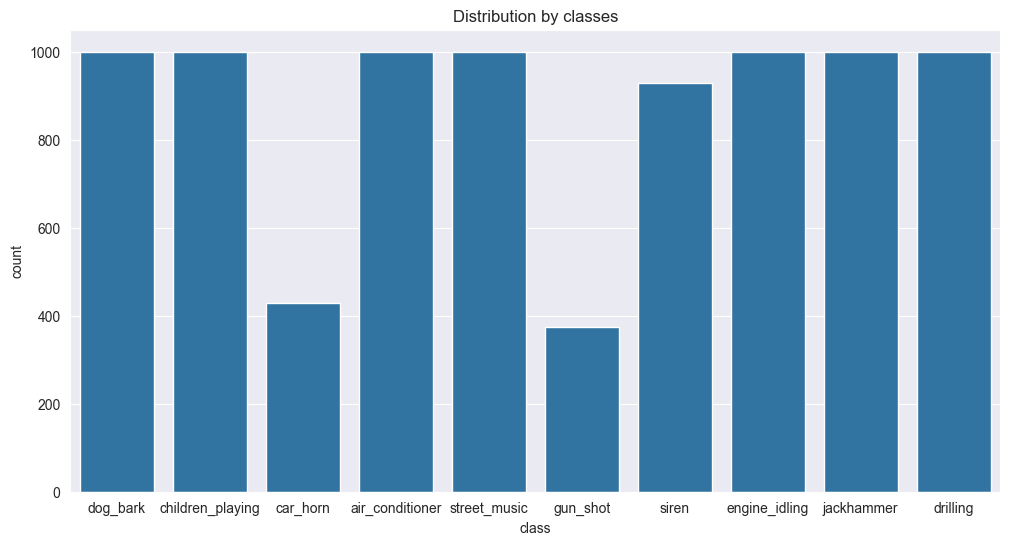

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='class')   # seaborn automatically counts occurrences
plt.title('Distribution by classes')
plt.show()

In [17]:
sample_y, sr = librosa.load(sample_file_name, sr=None)

print(f"Sample rate: {sr} Hz")
print(f"Audio data shape: {sample_y.shape}")

Sample rate: 44100 Hz
Audio data shape: (176400,)


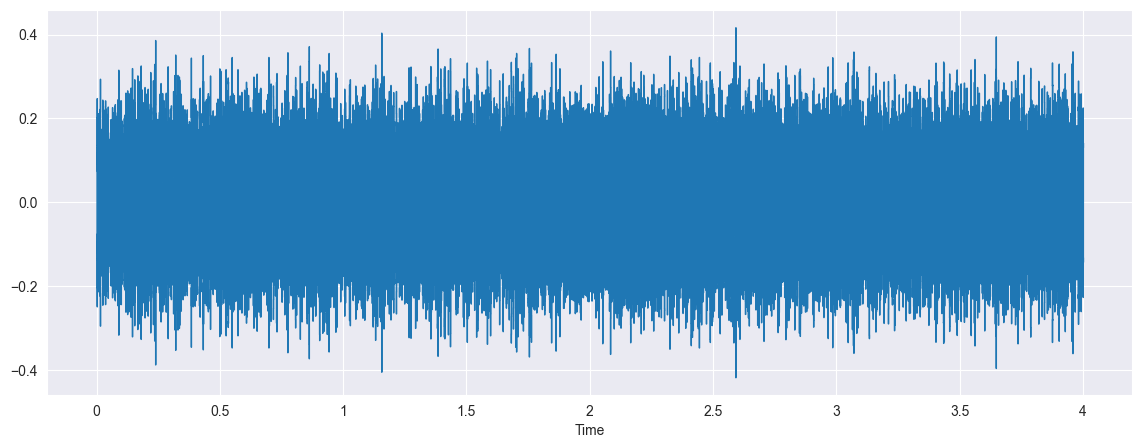

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_y, sr=sr)

Text(0, 0.5, 'Frequency (Hz)')

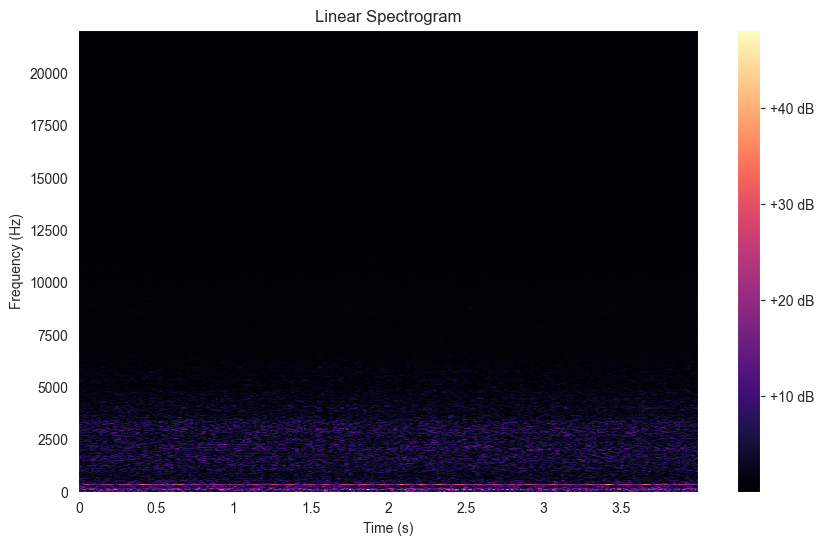

In [18]:
sample_stft = np.abs(librosa.stft(sample_y))
sample_db = librosa.amplitude_to_db(sample_stft, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(sample_stft, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

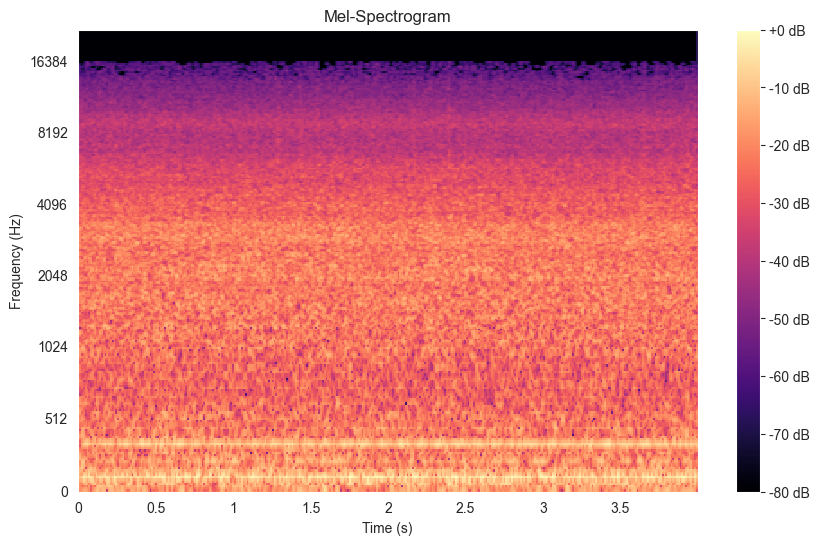

In [29]:
sample_mel_spec = librosa.feature.melspectrogram(y=sample_y, sr=sr, n_mels=256, fmax=sr//2)
mel_spec_db = librosa.power_to_db(sample_mel_spec, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()